# **BasketBall Playoffs**

### CSV information loaded into Dataframes

In [2]:
import pandas as pd

awards_players_df = pd.read_csv("data/awards_players.csv")
coaches_df = pd.read_csv("data/coaches.csv")
players_teams_df = pd.read_csv("data/players_teams.csv")
players_df = pd.read_csv("data/players.csv")
series_post_df = pd.read_csv("data/series_post.csv")
teams_post_df = pd.read_csv("data/teams_post.csv")
teams_df = pd.read_csv("data/teams.csv")
players_df.isna().all()

bioID           False
pos             False
firstseason     False
lastseason      False
height          False
weight          False
college         False
collegeOther    False
birthDate       False
deathDate       False
dtype: bool

### Dropping some columns and rows
Some invalid player entries were found with null values in every column.

We also dropped all columns relative to *lgID* as all rows had the same value in every dataframe


In [3]:
#death date isnt relevant and its value is always 0000-00-00
players_df = players_df.drop(["deathDate","firstseason","lastseason"], axis="columns")
#lgID(Winner/Loser) isnt relevant as its value is always the same
awards_players_df = awards_players_df.drop(["lgID"], axis="columns")
coaches_df = coaches_df.drop(["lgID"], axis="columns")
players_teams_df = players_teams_df.drop(["lgID"], axis="columns")
series_post_df = series_post_df.drop(["lgIDWinner","lgIDLoser"], axis="columns")
teams_post_df = teams_post_df.drop(["lgID"], axis="columns")
teams_df = teams_df.drop(["lgID","seeded","arena"], axis="columns")
#remove players whose birthDate is 0000-00-00
players_df = players_df[players_df['birthDate'] != '0000-00-00']
players_df = players_df.rename(columns={"bioID": "playerID"})
players_df

,playerID,pos,height,weight,college,collegeOther,birthDate
0,abrahta01w,C,74.0,190,George Washington,NaN,1975-09-27
1,abrossv01w,F,74.0,169,Connecticut,NaN,1980-07-09
2,adairje01w,C,76.0,197,George Washington,NaN,1986-12-19
3,adamsda01w,F-C,73.0,239,Texas A&M,Jefferson College (JC),1989-02-19
4,adamsjo01w,C,75.0,180,New Mexico,NaN,1981-05-24
...,...,...,...,...,...,...,...
887,zarafr01w,G,70.0,146,NaN,NaN,1976-12-08
888,zellosh01w,G,70.0,155,Pittsburgh,NaN,1986-08-28
889,zhengha01w,C,80.0,254,NaN,NaN,1967-03-07
891,zirkozu01w,G,69.0,145,NaN,NaN,1980-06-06


In [4]:
"""
merged_players_df = pd.merge(players_df, awards_players_df, how="left", on="playerID")
merged_players_df = pd.merge(merged_players_df, players_teams_df, how="left", on=["playerID","year"])
merged_df = pd.merge(teams_df, merged_players_df, how="left", on=["year", "tmID"])
merged_df = pd.merge(merged_df, coaches_df, how="left", on=["year", "tmID"])
merged_df = pd.merge(merged_df, teams_post_df, how="left", on=["year", "tmID"])
merged_df = pd.merge(merged_df, series_post_df, how="left", on="year")
"""

merged_df = pd.merge(players_teams_df, players_df, how="left", on=["playerID"])
merged_df = pd.merge(merged_df, awards_players_df, how="left", on=["playerID","year"])
merged_df["award"] = merged_df["award"].fillna("None")
teams_merged_df = pd.merge(teams_df, coaches_df, how="left", on=["year","tmID"])
merged_df = pd.merge(merged_df, teams_merged_df, how="left", on=["year","tmID"])



In [5]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
merged_df["playoff"] = encoder.fit_transform(merged_df["playoff"])

# print what was mapped to what
for idx, label in enumerate(encoder.classes_):
    print(f"{label}: {idx}")

N: 0
Y: 1


AttributeError: 'Legend' object has no attribute 'get_legend_handles_labels'

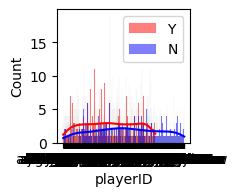

In [17]:

import matplotlib.pyplot as plt
import seaborn as sb

plt.figure(figsize=(25,25))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

merged_df1 = merged_df[merged_df['playoff']==1].drop(['playoff'],axis=1)
merged_df2 = merged_df[merged_df['playoff']==0].drop(['playoff'],axis=1)

cols = list(merged_df1.columns)

for i, col in enumerate(cols):
    plt.subplot(11,11,i+1)
    sb.histplot(data=merged_df1[col], color='red', label = 'Y', kde=True)
    sb.histplot(data=merged_df2[col], color='blue', label = 'N', kde=True)
    _,axes = plt.gca().get_legend_handles_labels()
    plt.legend(axes,prop={'size': 10})

plt.show()

In [22]:
merged_df.isna().any()


playerID       False
year           False
stint_x        False
tmID           False
GP_x           False
               ...  
stint_y        False
won_y          False
lost_y         False
post_wins      False
post_losses    False
Length: 111, dtype: bool
